In [76]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
from pyspark.sql.functions import split, explode
from pyspark.sql.functions import avg, length, col
from pyspark.sql.functions import year, to_timestamp

spark = SparkSession.builder.appName("YelpDataAnalysis").getOrCreate()
business_df = spark.read.json("file:///home/dps/Documents/yelp_dataset/yelp_academic_dataset_business.json")

In [17]:
arizona_business_df = business_df.filter(business_df.state == "AZ")

In [3]:
arizona_business_df.write.parquet("file:///home/dps/Documents/temp/arizona_business.parquet")

AnalysisException: [PATH_ALREADY_EXISTS] Path file:/home/dps/Documents/temp/arizona_business.parquet already exists. Set mode as "overwrite" to overwrite the existing path.

In [18]:
arizona_business_df = spark.read.parquet("file:///home/dps/Documents/temp/arizona_business.parquet")
arizona_business_df.show(5)

+--------------------+--------------------+--------------------+--------------------+------+--------------------+-------+----------+------------+--------------------+-----------+------------+-----+-----+
|             address|          attributes|         business_id|          categories|  city|               hours|is_open|  latitude|   longitude|                name|postal_code|review_count|stars|state|
+--------------------+--------------------+--------------------+--------------------+------+--------------------+-------+----------+------------+--------------------+-----------+------------+-----+-----+
|8581 N Silverbell Rd|{null, null, u'no...|2tAi411srrpmMofeA...|Coffee & Tea, Bre...|Tucson|{6:30-12:0, 0:0-0...|      1| 32.362689| -111.120753|Just Breakfast on...|      85743|         113|  3.5|   AZ|
|3655 N Oracle Rd,...|{null, null, null...|kdZr-IdMNOUNZxbZD...|Public Services &...|Tucson|{10:0-17:0, 10:0-...|      1| 32.273139|-110.9790247|      US Post Office|      85705|      

In [19]:
arizona_business_df.select("categories").distinct().show(truncate=False)
business_az_exploded = arizona_business_df.withColumn("category", explode(split(arizona_business_df["categories"], ", ")))
business_az_exploded.createOrReplaceTempView("business_az_exploded")

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|categories                                                                                                                                                               |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Gold Buyers, Shopping, Jewelry, Jewelry Repair, Local Services, Watches                                                                                                  |
|Boating, Playgrounds, Active Life, Fishing, Parks, Soccer                                                                                                                |
|Fashion, Accessories, Department Stores, Women's Clothing, Discount Store, Men's Clothing, Adult, Home & Garden, Shopping, Home Decor      

In [20]:
health_medical_df = arizona_business_df.filter(arizona_business_df.categories.contains("Health & Medical"))

In [21]:
checkin_df = spark.read.json("file:///home/dps/Documents/yelp_dataset/yelp_academic_dataset_checkin.json")
review_df = spark.read.json("file:///home/dps/Documents/yelp_dataset/yelp_academic_dataset_review.json")
tip_df = spark.read.json("file:///home/dps/Documents/yelp_dataset/yelp_academic_dataset_tip.json")
user_df = spark.read.json("file:///home/dps/Documents/yelp_dataset/yelp_academic_dataset_user.json")

In [8]:
checkin_df.write.parquet("file:///home/dps/Documents/temp/checkin.parquet")

AnalysisException: [PATH_ALREADY_EXISTS] Path file:/home/dps/Documents/temp/checkin.parquet already exists. Set mode as "overwrite" to overwrite the existing path.

In [9]:
review_df.write.parquet("file:///home/dps/Documents/temp/review.parquet")

AnalysisException: [PATH_ALREADY_EXISTS] Path file:/home/dps/Documents/temp/review.parquet already exists. Set mode as "overwrite" to overwrite the existing path.

In [10]:
tip_df.write.parquet("file:///home/dps/Documents/temp/tip.parquet")

AnalysisException: [PATH_ALREADY_EXISTS] Path file:/home/dps/Documents/temp/tip.parquet already exists. Set mode as "overwrite" to overwrite the existing path.

In [11]:
user_df.write.parquet("file:///home/dps/Documents/temp/user.parquet")

AnalysisException: [PATH_ALREADY_EXISTS] Path file:/home/dps/Documents/temp/user.parquet already exists. Set mode as "overwrite" to overwrite the existing path.

In [29]:
health_medical_reviews_df = health_medical_df.join(review_df, "business_id", "inner")

DataFrame[business_id: string, address: string, attributes: struct<AcceptsInsurance:string,AgesAllowed:string,Alcohol:string,Ambience:string,BYOB:string,BYOBCorkage:string,BestNights:string,BikeParking:string,BusinessAcceptsBitcoin:string,BusinessAcceptsCreditCards:string,BusinessParking:string,ByAppointmentOnly:string,Caters:string,CoatCheck:string,Corkage:string,DietaryRestrictions:string,DogsAllowed:string,DriveThru:string,GoodForDancing:string,GoodForKids:string,GoodForMeal:string,HairSpecializesIn:string,HappyHour:string,HasTV:string,Music:string,NoiseLevel:string,Open24Hours:string,OutdoorSeating:string,RestaurantsAttire:string,RestaurantsCounterService:string,RestaurantsDelivery:string,RestaurantsGoodForGroups:string,RestaurantsPriceRange2:string,RestaurantsReservations:string,RestaurantsTableService:string,RestaurantsTakeOut:string,Smoking:string,WheelchairAccessible:string,WiFi:string>, categories: string, city: string, hours: struct<Friday:string,Monday:string,Saturday:string

In [68]:
# simple query-1
query1_result = spark.sql("""
    SELECT
        category,
        COUNT(business_id) AS business_count
    FROM
        business_az_exploded
    GROUP BY
        category
    ORDER BY
        business_count DESC
    LIMIT 10
""")
query1_result.show()

+----------------+--------------+
|        category|business_count|
+----------------+--------------+
|     Restaurants|          2671|
|        Shopping|          1780|
|            Food|          1520|
|   Home Services|          1390|
|Health & Medical|          1032|
|   Beauty & Spas|           999|
|  Local Services|           935|
|      Automotive|           872|
|         Mexican|           547|
|       Nightlife|           546|
+----------------+--------------+



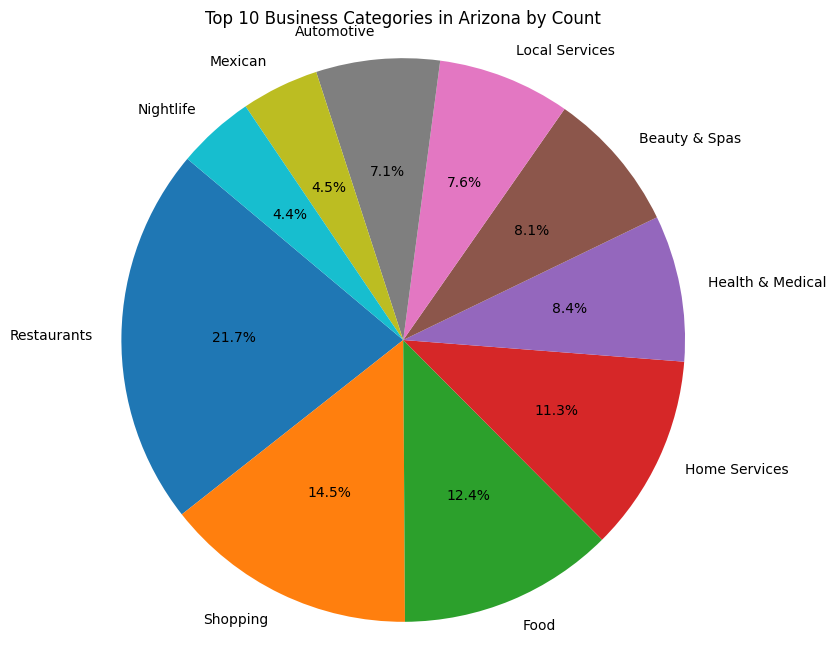

In [69]:
if query1_result is not None and query1_result.count() > 0:
    query1_pd = query1_result.toPandas()
    plt.figure(figsize=(8, 8))
    plt.pie(
        query1_pd['business_count'], 
        labels=query1_pd['category'], 
        autopct='%1.1f%%', 
        startangle=140
    )
    plt.title('Top 10 Business Categories in Arizona by Count')
    plt.axis('equal')
    plt.show()
else:
    print("No data returned by the query.")

In [61]:
#simple query-2
health_medical_df.createOrReplaceTempView("health_medical_az")
query2_result = spark.sql("""
    SELECT
        name,
        stars AS avg_rating,
        review_count
    FROM
        health_medical_az
    ORDER BY
        avg_rating DESC, review_count DESC
    LIMIT 10
""")
query2_result.show()

+--------------------+----------+------------+
|                name|avg_rating|review_count|
+--------------------+----------+------------+
|Lotus Massage & W...|       5.0|          97|
|Tucson Massage Co...|       5.0|          59|
|       The Busy Body|       5.0|          53|
| Massage by Michelle|       5.0|          49|
|            Spa Daze|       5.0|          48|
|      Precise Dental|       5.0|          46|
|  Body Altar Massage|       5.0|          46|
|Southwest Kids De...|       5.0|          40|
|Dentistry In Oro ...|       5.0|          36|
|Tanque Verde Pedi...|       5.0|          35|
+--------------------+----------+------------+



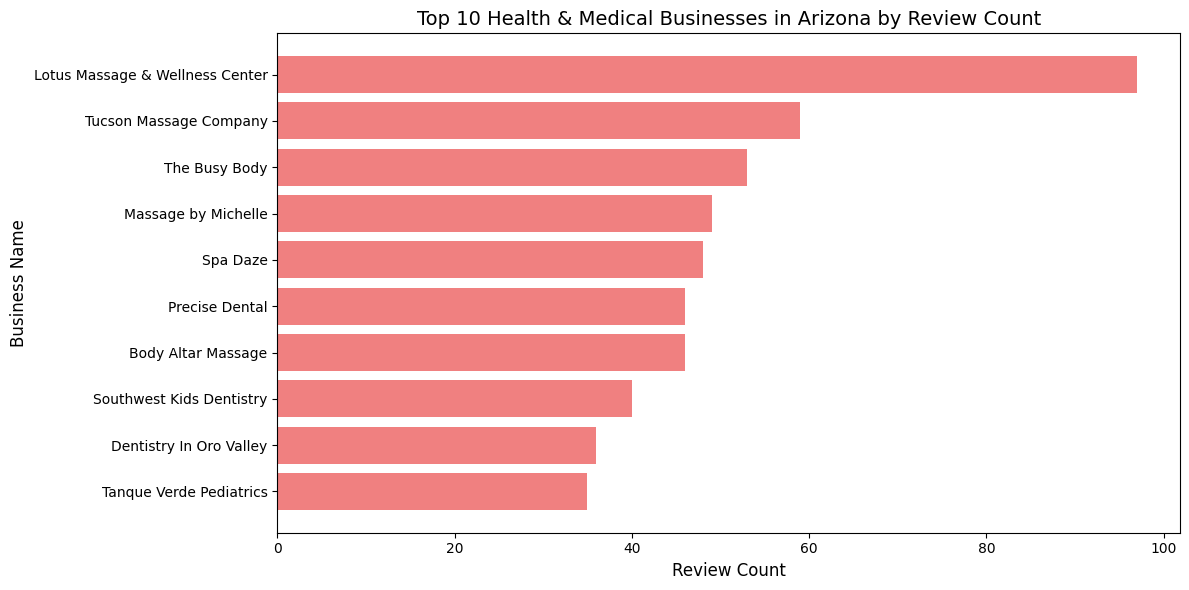

In [62]:
query_health_pd = query2_result.toPandas()
plt.figure(figsize=(12, 6))
plt.barh(query_health_pd['name'], query_health_pd['review_count'], color='lightcoral')
plt.xlabel('Review Count', fontsize=12)
plt.ylabel('Business Name', fontsize=12)
plt.title('Top 10 Health & Medical Businesses in Arizona by Review Count', fontsize=14)
plt.gca().invert_yaxis() 
plt.tight_layout()
plt.show()

In [70]:
#simple query-3
query3_result=spark.sql("""
    SELECT
        city,
        COUNT(business_id) AS business_count
    FROM
        health_medical_az
    GROUP BY
        city
    ORDER BY
        business_count DESC
    LIMIT 10
""")
query3_result.show()


+----------------+--------------+
|            city|business_count|
+----------------+--------------+
|          Tucson|           966|
|      Oro Valley|            45|
|          Marana|             6|
|    Green Valley|             5|
|            Vail|             4|
|       Sahuarita|             4|
|    South Tucson|             1|
|Corona de Tucson|             1|
+----------------+--------------+



In [71]:
#Complex query-1
query4_result = spark.sql("""
    SELECT
        postal_code,
        AVG(r.stars) AS avg_rating,
        COUNT(r.review_id) AS total_reviews
    FROM
        health_medical_az b
    JOIN
        review r
    ON
        b.business_id = r.business_id
    GROUP BY
        postal_code
    ORDER BY
        avg_rating DESC, total_reviews DESC
    LIMIT 10
""")
query4_result.show()


+-----------+------------------+-------------+
|postal_code|        avg_rating|total_reviews|
+-----------+------------------+-------------+
|      85735|               5.0|            6|
|      85752|               5.0|            5|
|      85658|             4.275|           40|
|      85742| 4.103174603174603|          126|
|      85716| 4.009389671361502|         1065|
|      85749| 3.989247311827957|           93|
|      85701|3.9551282051282053|          156|
|      85737|3.9419354838709677|          310|
|      85715| 3.765695067264574|          892|
|      85756|3.7333333333333334|           45|
+-----------+------------------+-------------+



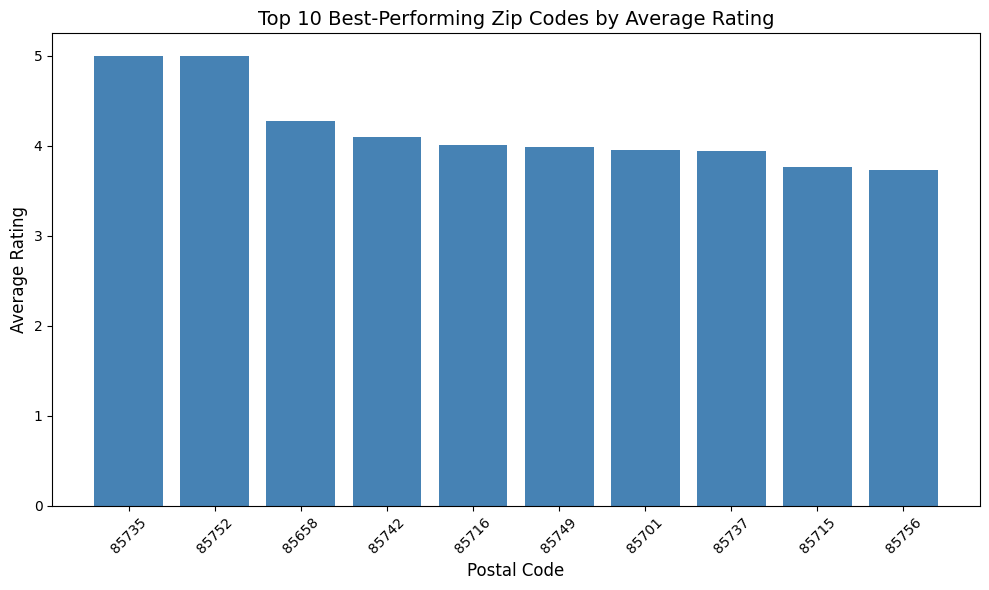

In [72]:
if query4_result is not None and query4_result.count() > 0:
    query4_pd = query4_result.toPandas()
    plt.figure(figsize=(10, 6))
    plt.bar(query4_pd['postal_code'], query4_pd['avg_rating'], color='steelblue')
    plt.xlabel('Postal Code', fontsize=12)
    plt.ylabel('Average Rating', fontsize=12)
    plt.title('Top 10 Best-Performing Zip Codes by Average Rating', fontsize=14)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("No data returned by the query.")


In [74]:
#complex query
query5_result = spark.sql("""
    SELECT
        b.business_id,
        b.name AS business_name,
        b.city,
        AVG(r.stars) AS average_rating,
        AVG(LENGTH(r.text)) AS average_review_length,
        AVG(r.useful) AS avg_useful,
        AVG(r.funny) AS avg_funny,
        AVG(r.cool) AS avg_cool
    FROM
        health_medical_az b
    JOIN
        review r
    ON
        b.business_id = r.business_id
    GROUP BY
        b.business_id, b.name, b.city
    ORDER BY
        average_rating DESC, average_review_length DESC
    LIMIT 10
""")

query5_result.show()


+--------------------+--------------------+----------+--------------+---------------------+--------------------+---------+-------------------+
|         business_id|       business_name|      city|average_rating|average_review_length|          avg_useful|avg_funny|           avg_cool|
+--------------------+--------------------+----------+--------------+---------------------+--------------------+---------+-------------------+
|VMWg_Hq-H1CRbClqL...|  Tucson Biofeedback|    Tucson|           5.0|   1399.6666666666667|  1.8333333333333333|      0.0| 0.6666666666666666|
|bZhEMLedWEOB7EfaH...| Old Pueblo CrossFit|    Tucson|           5.0|                979.4|                 0.4|      0.0|                0.2|
|biPVZx5C2s1xKIxfQ...|Switzer Family Ch...|    Tucson|           5.0|    821.4285714285714|  1.1428571428571428|      0.0|                0.0|
|LuPr_bctT1wVI8oG-...|   Old Pueblo Dental|    Tucson|           5.0|    818.9333333333333|                 0.6|      0.0|0.13333333333333333|

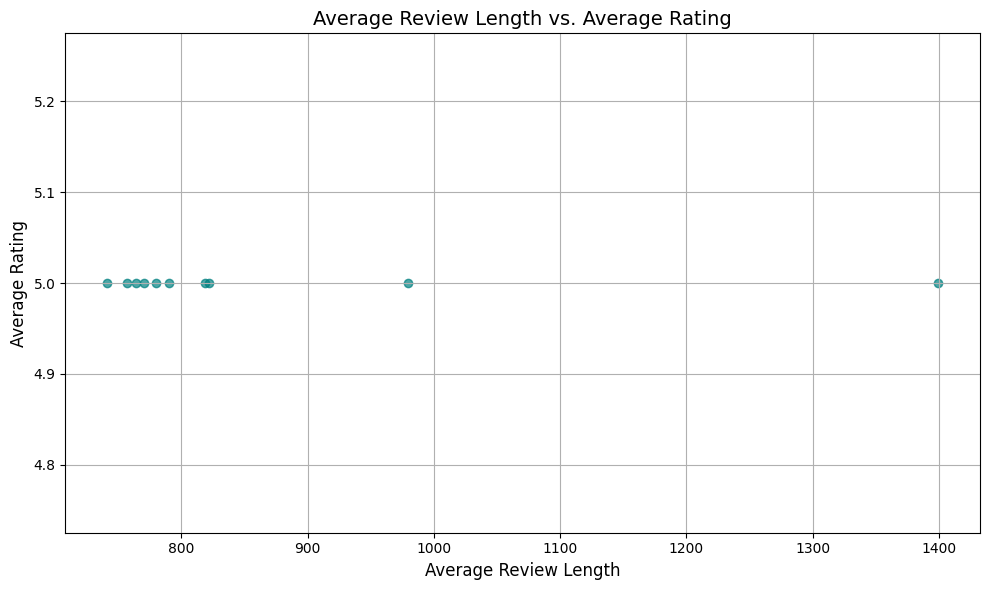

In [75]:
import matplotlib.pyplot as plt
sentiment_pd = query5_result.toPandas()
plt.figure(figsize=(10, 6))
plt.scatter(sentiment_pd['average_review_length'], sentiment_pd['average_rating'], color='teal', alpha=0.7)
plt.title('Average Review Length vs. Average Rating', fontsize=14)
plt.xlabel('Average Review Length', fontsize=12)
plt.ylabel('Average Rating', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


In [77]:
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")
health_medical_reviews_df = review_df.join(
    health_medical_df.select("business_id", "name", "city"),
    on="business_id",
    how="inner"
)
health_medical_reviews_with_year_df = health_medical_reviews_df.withColumn(
    "year", year(to_timestamp("date", "yyyy-MM-dd HH:mm:ss"))
)
health_medical_reviews_with_year_df.createOrReplaceTempView("health_reviews_year")
query6_result = spark.sql("""
    SELECT year,
           ROUND(AVG(stars), 2) AS avg_stars,
           COUNT(*) AS num_reviews
    FROM health_reviews_year
    WHERE year IS NOT NULL
    GROUP BY year
    ORDER BY year
""")

query6_result.show()


+----+---------+-----------+
|year|avg_stars|num_reviews|
+----+---------+-----------+
|2005|      4.0|          1|
|2006|      5.0|          4|
|2007|      4.0|          3|
|2008|      4.1|         20|
|2009|     3.35|         43|
|2010|     4.05|         91|
|2011|     3.92|        295|
|2012|     3.81|        537|
|2013|     3.59|        806|
|2014|     3.56|       1124|
|2015|     3.52|       1491|
|2016|     3.59|       1938|
|2017|     3.62|       2340|
|2018|     3.65|       2778|
|2019|     3.52|       2858|
|2020|     3.24|       2088|
|2021|     3.06|       2259|
|2022|     2.97|        127|
+----+---------+-----------+



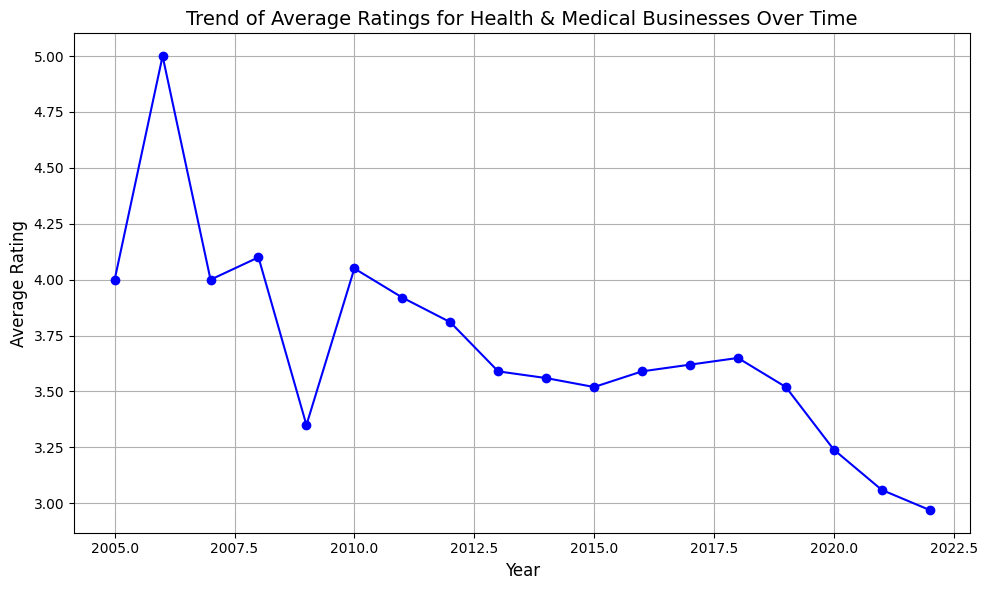

In [78]:
ratings_trend_pd = query6_result.toPandas()
plt.figure(figsize=(10, 6))
plt.plot(ratings_trend_pd['year'], ratings_trend_pd['avg_stars'], marker='o', color='blue')
plt.title('Trend of Average Ratings for Health & Medical Businesses Over Time', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Rating', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()
